In [1]:
import pandas as pd
import numpy as np
import re

import torch
import torch.optim as optim
# nlp library of Pytorch
from torchtext import data
from torch.utils.data import SubsetRandomSampler
from sklearn.model_selection import StratifiedKFold, train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
import random

import warnings as wrn
wrn.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)
#set inline plot size
plt.rcParams['figure.figsize'] = [6,4]

torch.cuda.is_available()

True

In [2]:
#set seed for reproducibility
seed = 1234
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
data_ = pd.read_csv('./train.csv')
data_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
data_.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1


# preprocessing

In [5]:
def remove_urls(text: str, replacement: str="") -> str:
    """Removes URLs from a given string."""
    """Also removes @ mentions."""
    # Define the regex used to identify URLs
    url_expression = (
        r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)"
        r"(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s("
        r")<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    )
    # Replace any URLs with the replacement string
    text1 = re.sub(url_expression, replacement, text)
    
    #remove @ mentions and return
    return re.sub(r"@[A-Za-z0-9]+", replacement, text1)

In [6]:
def remove_nonalphanumeric(text: np.str_) -> str:
    """
    Removes non-alphanumeric characters from a given string.
    
    Preserves spaces and quotation marks (to preserve contractions).
    """

    return re.sub("[^A-Za-z0-9 '\"]+", '', text)

In [7]:
# #removing duplicate tweets
# df['text_lower'] = df.text.str.lower()
# df = df.drop_duplicates(subset=['text_lower'], keep='first')
# df = df.reset_index(drop=True)

In [8]:
def preprocessing(df):
    
    out_df = df.copy()
    
    out_df["text"] = out_df["text"].apply(remove_urls) # Must be done first
    out_df["text"] = out_df["text"].apply(remove_nonalphanumeric)
    #remove irrelevant string
    out_df['text'] = out_df.text.str.replace('I liked a YouTube video', '').replace('I added a video to a YouTube playlist', '')
    
    return out_df

# Torchtext Example

In [9]:
TEXT = data.Field(tokenize='spacy', 
                  tokenizer_language='en_core_web_sm', 
                  batch_first=True,
                  include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

#fields = [(None, None),(None, None),(None, None),('text', TEXT),("target", LABEL)]
fields = [('text', TEXT),("target", LABEL)]

In [10]:
# source : https://gist.github.com/lextoumbourou/8f90313cbc3598ffbabeeaa1741a11c8
# to use DataFrame as a Data source

class DataFrameDataset(data.Dataset):

    def __init__(self, df, fields, is_test=False, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.target if not is_test else None
            text = row.text
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field, True, **kwargs)
        
        out = tuple(d for d in (train_data, val_data, test_data) if d is not None)
        
        if len(out) == 1:
            return out[0]
        
        return out

In [11]:
example_data = DataFrameDataset.splits(fields = fields, train_df=data_.iloc[:100,])
print(vars(example_data[0]))

{'text': ['Our', 'Deeds', 'are', 'the', 'Reason', 'of', 'this', '#', 'earthquake', 'May', 'ALLAH', 'Forgive', 'us', 'all'], 'target': 1}


In [12]:
# Building vocabularies => (Token to integer)
TEXT.build_vocab(example_data,
                 min_freq=5)

LABEL.build_vocab(example_data)

print("Size of text vocab:",len(TEXT.vocab))
print("Size of label vocab:",len(LABEL.vocab))

Size of text vocab: 39
Size of label vocab: 2


In [13]:
TEXT.vocab.freqs.most_common(10)

[('#', 50),
 ('?', 37),
 ('.', 32),
 ('in', 32),
 ('the', 27),
 (':', 26),
 ('I', 25),
 ('to', 21),
 ('ablaze', 20),
 ('a', 18)]

In [14]:
# # Creating GPU variable
# device = torch.device("cuda")

# BATCH_SIZE = 64

# # We'll create iterators to get batches of data when we want to use them
# """
# This BucketIterator batches the similar length of samples and reduces the need of 
# padding tokens. This makes our future model more stable

# """
# train_iterator,validation_iterator = data.BucketIterator.splits(
#     (train_data,valid_data),
#     batch_size = BATCH_SIZE,
#     # Sort key is how to sort the samples
#     sort_key = lambda x:len(x.text),
#     sort_within_batch = True,
#     device = device
# )

# LSTM

In [15]:
# Pytorch's nn module has lots of useful feature
import torch.nn as nn

class LSTMNet(nn.Module):
    
    def __init__(self,vocab_size,embedding_dim,hidden_dim,output_dim,n_layers,bidirectional,dropout):
        
        super(LSTMNet,self).__init__()
        
        # Embedding layer converts integer sequences to vector sequences
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        
        # LSTM layer process the vector sequences 
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout,
                            batch_first = True
                           )
        
        # Dense layer to predict 
        self.fc = nn.Linear(hidden_dim * 2,output_dim)
        # Prediction activation function
        self.sigmoid = nn.Sigmoid()
        
    
    def forward(self,text,text_lengths):
        embedded = self.embedding(text)
        
        # Thanks to packing, LSTM don't see padding tokens 
        # and this makes our model better
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(),batch_first=True)
        
        packed_output,(hidden_state,cell_state) = self.lstm(packed_embedded)
        
        # Concatenating the final forward and backward hidden states
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
        
        dense_outputs=self.fc(hidden)

        #Final activation function
        outputs=self.sigmoid(dense_outputs)
        
        return outputs

In [16]:
# We'll use this helper to compute f1 score
def compute_f1_score(y_pred, y_true):
    #round predictions to the closest integer
    y_pred = torch.round(y_pred)
    tp = sum((y_true == 1) & (y_pred == 1))
    tn = sum((y_true == 0) & (y_pred == 0))
    fn = sum((y_true == 1) & (y_pred == 0))
    fp = sum((y_true == 0) & (y_pred == 1))
    precision = (tp)/ float( tp + fp)
    recall = (tp)/ float( tp + fn)
    f1_score = (2*precision*recall)/ (precision + recall)
    return f1_score

# We'll use this helper to compute accuracy
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

def train(model,iterator,optimizer,criterion):
    
    epoch_loss = 0.0
    epoch_acc = 0.0
    epoch_f1 = 0.0
    
    model.train()
    
    for batch in iterator:
        
        # cleaning the cache of optimizer
        optimizer.zero_grad()
        
        text,text_lengths = batch.text
        
        # forward propagation and squeezing
        predictions = model(text,text_lengths).squeeze()
        
        # computing loss / backward propagation
        loss = criterion(predictions,batch.target)
        loss.backward()
        
        # accuracy
        acc = binary_accuracy(predictions,batch.target)
        
        #f1 score
        f1 = compute_f1_score(predictions,batch.target)
        
        # updating params
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_f1 += f1.item()
        
    # It'll return the means of loss and accuracy, and f1
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1 / len(iterator)

def evaluate(model,iterator,criterion):
    
    epoch_loss = 0.0
    epoch_acc = 0.0
    epoch_f1 = 0.0
    
    # deactivate the dropouts
    model.eval()
    
    # Sets require_grad flat False
    with torch.no_grad():
        for batch in iterator:
            text,text_lengths = batch.text
            
            predictions = model(text,text_lengths).squeeze()
              
            #compute loss and accuracy
            loss = criterion(predictions, batch.target)
            acc = binary_accuracy(predictions, batch.target)
            f1 = compute_f1_score(predictions,batch.target)
            
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_f1 += f1.item()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1 / len(iterator)

In [17]:
#function for plotting loss and accuracy

my_colors = ["#21295C", "#1F4E78", "#1C7293", "#73ABAF", "#C9E4CA", "#87BBA2", "#618E83", "#3B6064"]

def plot_loss_acc_graph(train_losses, valid_losses, type_):
    '''Lineplot of the training/validation losses.'''

    sns.lineplot(y=train_losses, x=range(len(train_losses)),
                 lw=2.3, ls=":", color=my_colors[1], label="train")
    sns.lineplot(y=valid_losses, x=range(len(valid_losses)),
                 lw=2.3, ls="-", color=my_colors[6], label="valid")
    
    plt.title(type_)
    plt.xlabel('Epoch')
    plt.ylabel(type_)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    plt.show()

In [18]:
# Creating GPU variable
device = torch.device("cuda")

#set parameters
BATCH_SIZE = 64
EMBEDDING_DIM = 300
NUM_HIDDEN_NODES = 64
NUM_OUTPUT_NODES = 1
NUM_LAYERS = 3
BIDIRECTION = True
DROPOUT = 0.3
N_SPLITS = 3
EPOCH_NUMBER = 12

#init cross validation
skf = StratifiedKFold(n_splits = N_SPLITS, random_state=seed, shuffle=True)



100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:16<00:00,  1.37s/it]

FOLD: 1/3


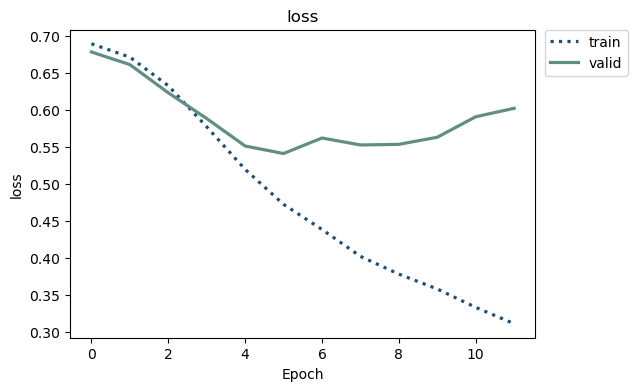

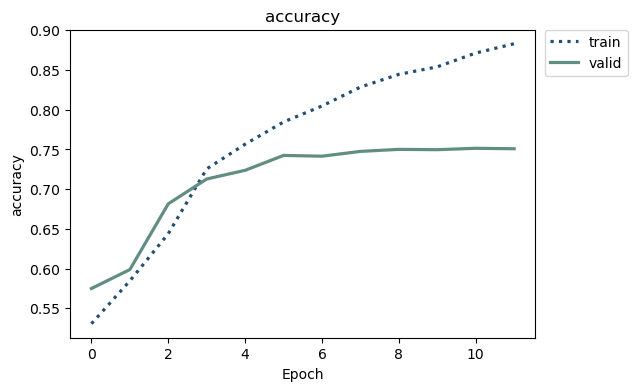

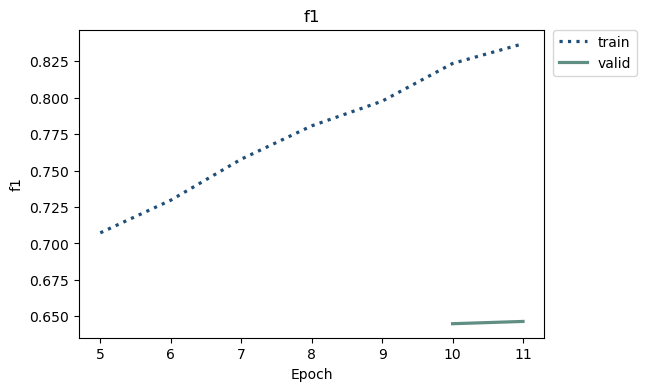

100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:16<00:00,  1.35s/it]

FOLD: 2/3


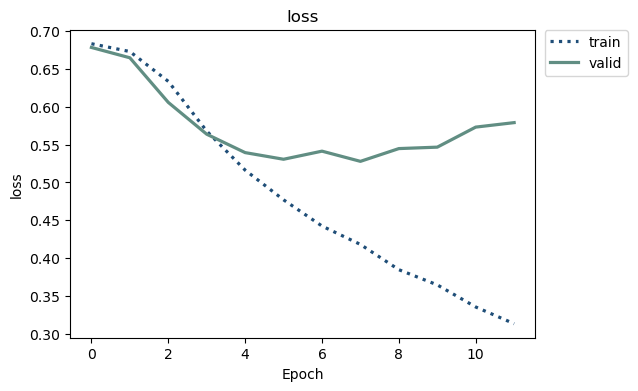

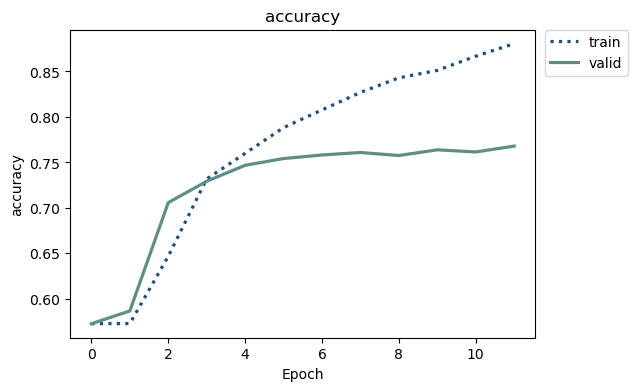

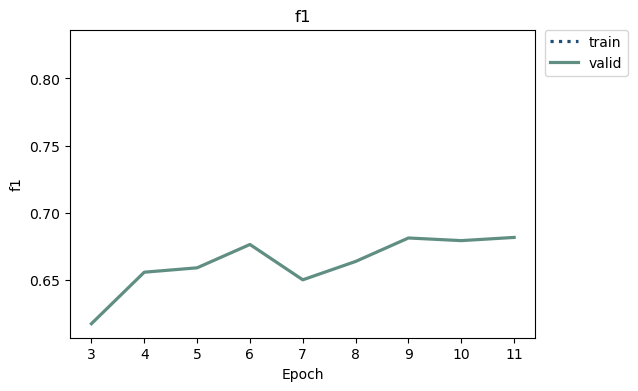

100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:16<00:00,  1.34s/it]

FOLD: 3/3


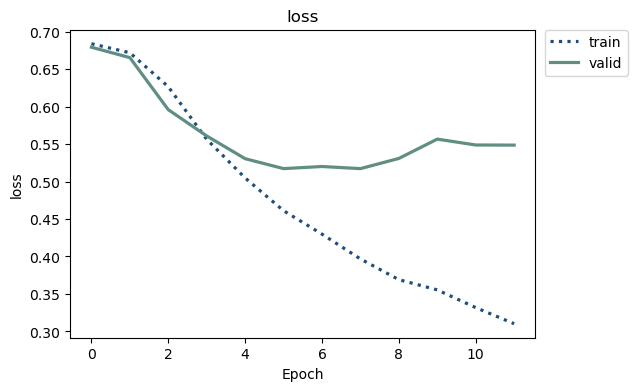

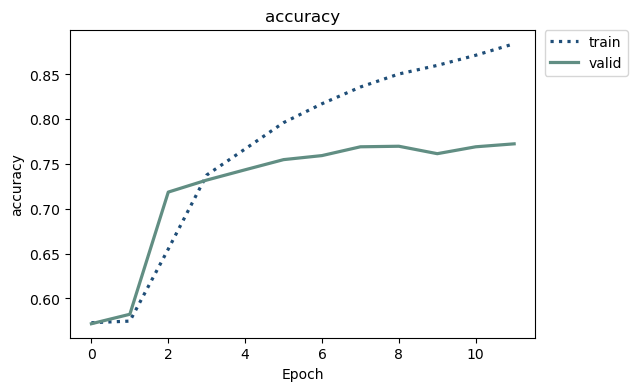

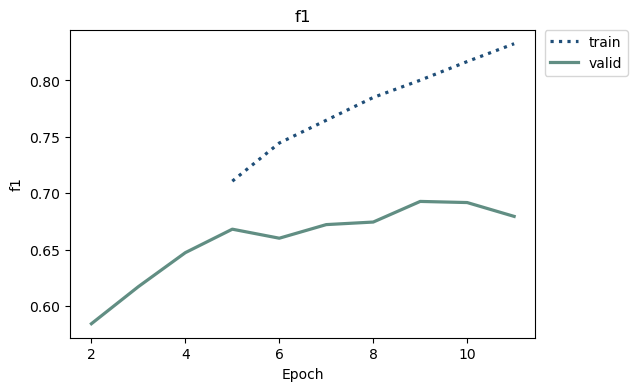


---------------
Mean Validation Loss: 0.5765081271529198
Mean Validation Accuracy: 0.763786052664121
Mean Validation F1: 0.6692292736222347
EMBEDDING_DIM: 300
NUM_HIDDEN_NODES: 64
NUM_LAYERS: 3
BIDIRECTION: True
DROPOUT: 0.3
NUM_HIDDEN_NODES: 64

Done.


In [19]:
data_ = preprocessing(data_)

val_loss_list, val_acc_list, val_f1_list = [], [], []

for fold, (train_idx,val_idx) in enumerate(skf.split(X=data_, y=data_["target"])):
    
    train_df = data_.iloc[train_idx]
    val_df = data_.iloc[val_idx]
    
    #preprocessing
    train_data = DataFrameDataset.splits(fields = fields, train_df=train_df)    
    valid_data = DataFrameDataset.splits(fields = fields, train_df=val_df) 
    TEXT.build_vocab(train_data, min_freq=5)
    LABEL.build_vocab(train_data)
    
    # We'll create iterators to get batches of data when we want to use them
    """
    This BucketIterator batches the similar length of samples and reduces the need of 
    padding tokens. This makes our future model more stable

    """
    train_iterator,validation_iterator = data.BucketIterator.splits(
        (train_data,valid_data),
        batch_size = BATCH_SIZE,
        # Sort key is how to sort the samples
        sort_key = lambda x:len(x.text),
        sort_within_batch = True,
        device = device
    )
    
    #model
    SIZE_OF_VOCAB = len(TEXT.vocab)
    model = LSTMNet(SIZE_OF_VOCAB,
                    EMBEDDING_DIM,
                    NUM_HIDDEN_NODES,
                    NUM_OUTPUT_NODES,
                    NUM_LAYERS,
                    BIDIRECTION,
                    DROPOUT
                   )

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(),lr=1e-4)
    criterion = nn.BCELoss()
    criterion = criterion.to(device)
    
    #dicts for saving results
    lossdict={'train':[],'val':[]}
    accdict={'train':[],'val':[]}
    f1dict={'train':[],'val':[]}
    
    #start run
    for epoch in tqdm(range(1,EPOCH_NUMBER+1)):

        train_loss,train_acc,train_f1 = train(model,train_iterator,optimizer,criterion)

        valid_loss,valid_acc,valid_f1 = evaluate(model,validation_iterator,criterion)
        
        lossdict['train'].append(train_loss)
        lossdict['val'].append(valid_loss)
        accdict['train'].append(train_acc)
        accdict['val'].append(valid_acc)
        f1dict['train'].append(train_f1)
        f1dict['val'].append(valid_f1)
        
        ## Showing statistics
        # print('EPOCH:', epoch)
        # print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        # print()
    
    val_loss_list.append(valid_loss)
    val_acc_list.append(valid_acc)
    val_f1_list.append(valid_f1)
    
    #plot results
    print(f'FOLD: {fold+1}/{N_SPLITS}')
    plot_loss_acc_graph(lossdict['train'], lossdict['val'], 'loss')
    plot_loss_acc_graph(accdict['train'], accdict['val'], 'accuracy')
    plot_loss_acc_graph(f1dict['train'], f1dict['val'], 'f1')
    print()
    
print('---------------')
print('Mean Validation Loss:', np.mean(val_loss_list))
print('Mean Validation Accuracy:', np.mean(val_acc_list))
print('Mean Validation F1:', np.mean(val_f1_list))
print('EMBEDDING_DIM:', EMBEDDING_DIM)
print('NUM_HIDDEN_NODES:', NUM_HIDDEN_NODES)
print('NUM_LAYERS:', NUM_LAYERS)
print('BIDIRECTION:', BIDIRECTION)
print('DROPOUT:', DROPOUT)
print('NUM_HIDDEN_NODES:', NUM_HIDDEN_NODES)

print()
print('Done.')

https://www.interviewbit.com/blog/deep-learning-vs-machine-learning/

The accuracy of models highly depends on the size of the input dataset that is fed to the machines. When the dataset is small ML models are preferable. Similarly, when the dataset is large, deep learning models are preferable. It also depends on the quality of training data. If you’ve not done feature engineering properly then ML models could show poor results even on a small dataset.  